In [1]:
# prerequisites
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

from scipy.stats import norm
from scipy import stats as sps 
import scipy
from scipy.spatial import distance
from scipy.stats import ks_2samp
from scipy.stats import multivariate_normal

import random
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import torch

In [3]:
# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)

# network parameters
batch_size, n_epoch = 101, 50
n_hidden, z_dim = 256, 16

(60000, 784) (10000, 784)


In [4]:
x_f, y_f = [], [] 
rmv_idx = []

for i in range(10): 
    if i % 2 != 0: 
        
        # 1,3,5,7,9 
        idf_i = list(np.where(y_tr == i)[0]) 
        
        y_f.append([i]*len(idf_i))
        x_f.append(x_tr[idf_i]) 
        
            
        # remove elements by index list 
        rmv_idx += idf_i
             
x_tr = np.delete(x_tr, rmv_idx, axis=0) 
y_tr = np.delete(y_tr, rmv_idx, axis=0) 
        
x_f = np.array(x_f) 
y_f = np.array(y_f)

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [5]:
print(x_tr.shape, x_te.shape)

(29492, 784) (10000, 784)


In [6]:
# encoder
x = Input(shape=(x_tr.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)
z  = Dense(z_dim)(x_encoded)

In [7]:
# decoder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

In [ ]:
# loss
reconstruction_loss = binary_crossentropy(x, y) * x_tr.shape[1]
mlp_loss = reconstruction_loss

# build model
mlp = Model(x, y)
mlp.add_loss(mlp_loss)
mlp.compile(optimizer='rmsprop')
mlp.summary()

In [9]:
# train
mlp.fit(x_tr,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       verbose=1)

Epoch 1/50
292/292 [==============================] - 2s 5ms/step - loss: 204.6367
Epoch 2/50
292/292 [==============================] - 1s 5ms/step - loss: 125.6833
Epoch 3/50
292/292 [==============================] - 1s 5ms/step - loss: 109.7948
Epoch 4/50
292/292 [==============================] - 1s 5ms/step - loss: 101.9237
Epoch 5/50
292/292 [==============================] - 1s 5ms/step - loss: 97.1935
Epoch 6/50
292/292 [==============================] - 1s 5ms/step - loss: 93.6404
Epoch 7/50
292/292 [==============================] - 1s 5ms/step - loss: 90.8526
Epoch 8/50
292/292 [==============================] - 1s 5ms/step - loss: 89.0197
Epoch 9/50
292/292 [==============================] - 1s 5ms/step - loss: 87.6866
Epoch 10/50
292/292 [==============================] - 1s 5ms/step - loss: 86.2752
Epoch 11/50
292/292 [==============================] - 1s 5ms/step - loss: 85.4287
Epoch 12/50
292/292 [==============================] - 1s 5ms/step - loss: 84.4346
Epoch 13/

In [10]:
# build encoder
encoder = Model(x, z)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
Total params: 235,920
Trainable params: 235,920
Non-trainable params: 0
_________________________________________________________________


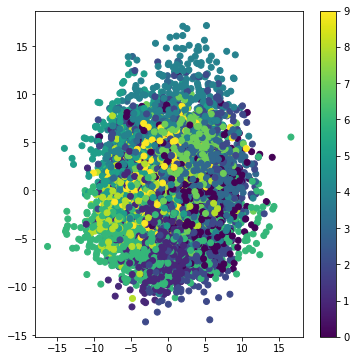

In [11]:
# Plot of the digit classes in the latent space
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te)
plt.colorbar()
plt.show()

In [12]:
# build decoder
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)

generator = Model(decoder_input, _y)
generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               201488    
Total params: 236,688
Trainable params: 236,688
Non-trainable params: 0
_________________________________________________________________


# Few Shot Sampling

In [14]:
# https://github.com/Michedev/VAE_anomaly_detection/blob/0a9eb14b7df226e8195c77d145a0f586ecbb6d67/VAE.py#L7
def softplus(x):
    return np.log(1+np.exp(x))

from dictances import bhattacharyya, bhattacharyya_coefficient

In [15]:
# build model
mlp_enc = Model(x, z)

mlp_enc.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
Total params: 235,920
Trainable params: 235,920
Non-trainable params: 0
_________________________________________________________________


In [16]:
test_classes = []

for i in range(y_f.shape[0]):
    test_classes.append(y_f[i][0])
    
print(test_classes)

[1, 3, 5, 7, 9]


In [17]:
# Mahalanobis Distance
def mahalanobis(x=None, mean=None, cov=None):

    x_mu = x - mean
    inv_covmat = np.linalg.inv(cov)
    
    left = np.dot(x_mu, inv_covmat)
        
    mahal = np.dot(left, x_mu.T)
        
    return mahal

In [25]:
n_way = 3 # number of classes
n_shot = 1 # number of samples per class

n_trial = 0
n_true = 0
n_false = 0

n_test = 1200

g_train_images, g_train_gt_labels = np.load(str(n_way)+"-"+str(n_shot)+'.npz')["trainImage"],np.load(str(n_way)+"-"+str(n_shot)+'.npz')["trainLabel"]
g_test_images, g_test_gt_labels = np.load(str(n_way)+"-"+str(n_shot)+'.npz')["testImage"],np.load(str(n_way)+"-"+str(n_shot)+'.npz')["testLabel"]
g_ways = np.load(str(n_way)+"-"+str(n_shot)+'.npz')["ways"]


for ntest in tqdm(range(n_test)):
    #print("Test Classes: {}".format(test_classes))

    # Load test data
    test_images = g_test_images[ntest]
    test_gt_labels = g_test_gt_labels[ntest]


    train_images = g_train_images[ntest]
    train_gt_labels = g_train_gt_labels[ntest]
    
    ways = g_ways[ntest]

    train_mus = []

    for image in train_images:
        res = mlp_enc.predict(image)
        mu_val = res[0][0]

        train_mus.append(mu_val)


    test_mus = []

    for image in test_images:
        res = mlp_enc.predict(image)
        mu_val = res[0][0]

        test_mus.append(mu_val)

    ###########################
    # Averaging mean's and mu's for each class
    alpha = 1 / n_shot
    avg_train_mus = []
    
    # average the mu variable
    for i in range(0,len(train_mus) - 1, n_shot):
        
        avg_mu = np.mean(train_mus[i: i + n_shot], axis=0)
        
        # class oriented mu
        avg_train_mus.append(avg_mu)


    #print(train_mus, train_vars)
    #print(avg_train_mus, avg_train_vars)

    test_pred_labels= []
    for i in range(len(test_mus)):
        test_dist = test_mus[i]

        local_scores = []
        for j in range(len(avg_train_mus)):
                        
            scr = np.sqrt((test_dist - avg_train_mus[j])**2)
            
            local_scores.append(scr)

        # get the minimum mahalanobis distance
        pred_cls_idx = np.argmin(local_scores)
        test_pred_labels.append(ways[pred_cls_idx])


    for i in range(len(test_gt_labels)):
        if test_gt_labels[i] == test_pred_labels[i]:
            n_true += 1
        else:
            n_false += 1

        n_trial += 1

100%|██████████| 1200/1200 [03:17<00:00,  6.09it/s]


In [27]:
print("N-way: {} - N-shot: {}".format(n_way,n_shot))
print("Acc: {:.5f} in {} different trials".format(n_true/n_trial, n_test))

N-way: 3 - N-shot: 1
Acc: 0.40583 in 1200 different trials


#####
#####
#####

In [ ]:
# output of test images in terms of mu,sigma
test_0 = scipy.stats.multivariate_normal(test_mus[0], np.diag(test_vars[0]))
test_1 = scipy.stats.multivariate_normal(test_mus[1], np.diag(test_vars[1]))
test_2 = scipy.stats.multivariate_normal(test_mus[2], np.diag(test_vars[2]))

print(np.mean(np.sum(sps.multivariate_normal(avg_train_mus[0], avg_train_logvars[0]).pdf(test_2.rvs(1)))))
print(np.mean(np.sum(sps.multivariate_normal(avg_train_mus[1], avg_train_logvars[1]).pdf(test_2.rvs(1)))))
print(np.mean(np.sum(sps.multivariate_normal(avg_train_mus[2], avg_train_logvars[2]).pdf(test_2.rvs(1)))))

In [ ]:
eps = K.random_normal(shape=(100, z_dim), mean=0., stddev=1.0)

dist_a1 = train_mus[0] + K.exp(train_logvars[0]) * eps
dist_a2 = train_mus[2] + K.exp(train_logvars[2]) * eps
dist_b1 = train_mus[10] + K.exp(train_logvars[10]) * eps
dist_b2 = train_mus[14] + K.exp(train_logvars[14]) * eps


m_a1, std_a1 = np.mean(np.array(dist_a1)), np.std(np.array(dist_a1))
m_a2, std_a2 = np.mean(np.array(dist_a2)), np.std(np.array(dist_a2))
m_b1, std_b1 = np.mean(np.array(dist_b1)), np.std(np.array(dist_b1))
m_b2, std_b2 = np.mean(np.array(dist_b2)), np.std(np.array(dist_b2))


x_a1 = np.random.normal(m_a1, std_a1, 100)
x_a2 = np.random.normal(m_a2, std_a2, 100)
x_b1 = np.random.normal(m_b1, std_b1, 100)
x_b2 = np.random.normal(m_b2, std_b2, 100)


#######################
multivariate_a1 = scipy.stats.multivariate_normal(train_mus[0], np.diag(np.exp(train_logvars[0])))
multivariate_a2 = scipy.stats.multivariate_normal(train_mus[2], np.diag(np.exp(train_logvars[2])))
multivariate_b1 = scipy.stats.multivariate_normal(train_mus[10], np.diag(np.exp(train_logvars[10])))
multivariate_b2 = scipy.stats.multivariate_normal(train_mus[14], np.diag(np.exp(train_logvars[14])))

multivariate_1 = scipy.stats.multivariate_normal(avg_train_mus[0], np.diag(np.exp(avg_train_logvars[0])))
multivariate_2 = scipy.stats.multivariate_normal(avg_train_mus[1], np.diag(np.exp(avg_train_logvars[1])))
multivariate_3 = scipy.stats.multivariate_normal(avg_train_mus[2], np.diag(np.exp(avg_train_logvars[2])))

In [ ]:
test_sample = sps.multivariate_normal.rvs(test_mus[2], np.diag(test_logvars[2]), 10)
print(np.mean(multivariate_1.pdf(test_sample)))
print(np.mean(multivariate_2.pdf(test_sample)))
print(np.mean(multivariate_3.pdf(test_sample)))

In [ ]:
test_sample

In [ ]:
ks_2samp(x_a1, x_a1)

In [ ]:
ks_2samp(x_a1, x_a2)

In [ ]:
ks_2samp(x_a1, x_b1)

In [ ]:
ks_2samp(x_a2, x_b1)

In [ ]:
ks_2samp(x_a2, x_b2)

In [ ]:
ks_2samp(x_a1, x_b2)

In [ ]:
ks_2samp(x_b1, x_b2)

In [ ]:
multivariate_a1.pdf((multivariate_a1.rvs())), multivariate_a1.pdf((multivariate_a2.rvs()))

In [ ]:
multivariate_a2.pdf((multivariate_b1.rvs())), multivariate_a1.pdf((multivariate_b2.rvs()))